## Detecting credit card fraud

Using this credit card fraud dataset develop an algorithm to predict fraud. Prioritize correctly finding fraud rather than correctly labeling non-fraudulent transactions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, f1_score
from inspect import signature

sns.set_style('darkgrid')

#### The dataset has been reduced to 28 PCA dimensions plus the amount, class, and time. We read this into a dataframe and run boxplots of the dimensions separated by class.

In [2]:
df = pd.read_csv('../../../Supervised_lesson6/Credit_card_fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


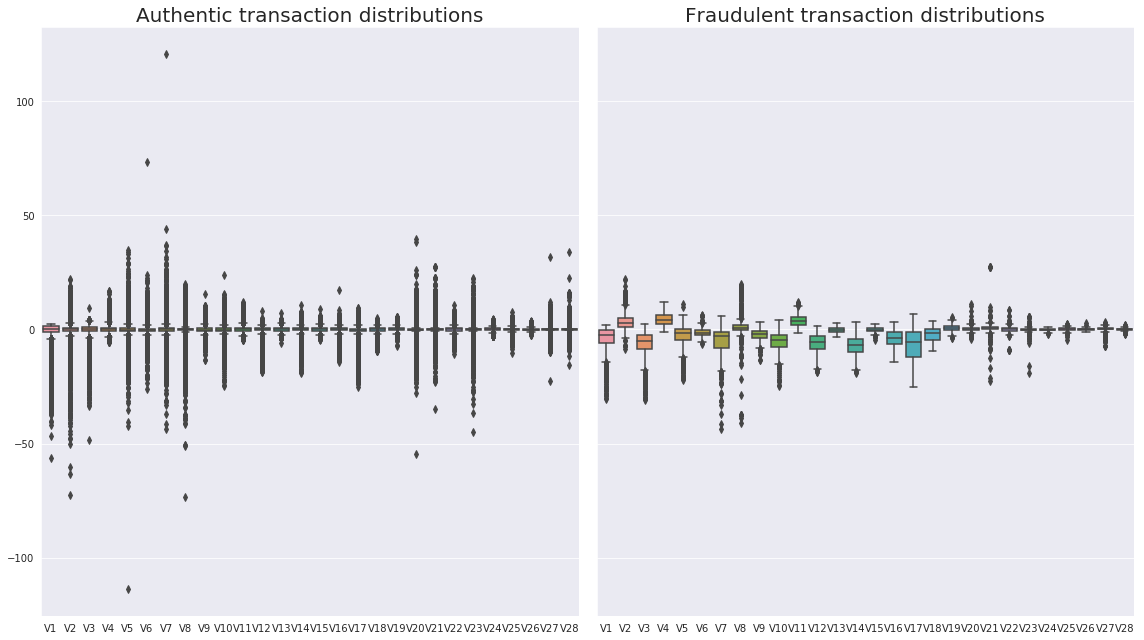

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey='row', figsize=(16,9))
# fig.suptitle('Distributions of values in features')
sns.boxplot(data=df.drop(['Time', 'Amount', 'Class'], axis=1), ax=ax1)
ax1.set_title('Authentic transaction distributions', size=20)
sns.boxplot(data=df[df.Class == 1].drop(['Time', 'Amount', 'Class'], axis=1), ax=ax2)
ax2.set_title('Fraudulent transaction distributions', size=20)
plt.tight_layout()

#### Some extreme outliers might be distorting the data. Let's observe without them.

In [5]:
df[df.Amount > 17500]

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
58465,48401.0,-36.802320,-63.344698,-20.645794,16.715537,-20.672064,7.694002,24.956587,-4.730111,-2.687312,...,11.455313,-10.933144,-17.173665,1.180700,-7.025783,-2.534330,-3.602479,3.450224,19656.53,0
151296,95286.0,-34.549296,-60.464618,-21.340854,16.875344,-19.229075,6.335259,24.422716,-4.964566,0.188912,...,11.502580,-9.499423,-16.513186,0.744341,-7.081325,-2.604551,-3.550963,3.250802,18910.00,0
274771,166198.0,-35.548539,-31.850484,-48.325589,15.304184,-113.743307,73.301626,120.589494,-27.347360,-3.872425,...,-21.620120,5.712303,-1.581098,4.584549,4.554683,3.415636,31.612198,-15.430084,25691.16,0


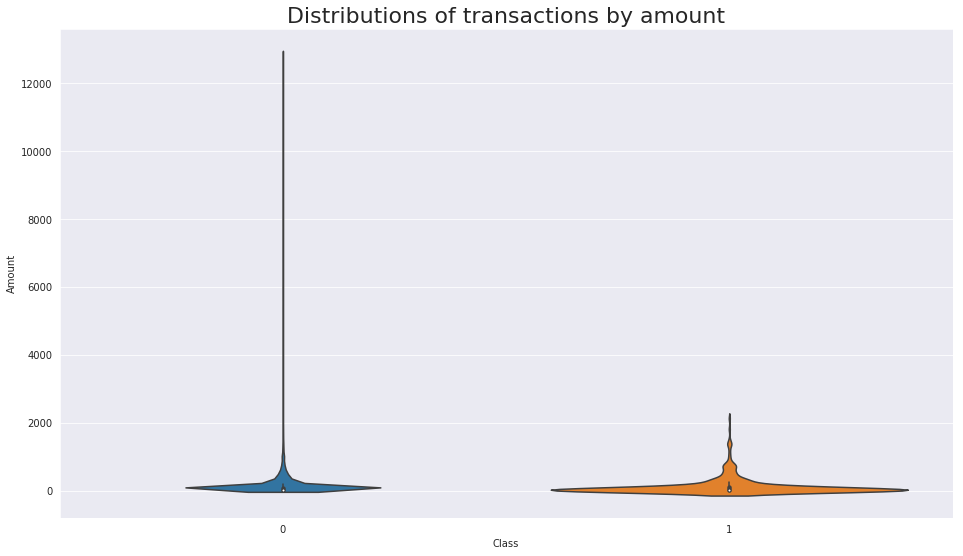

In [6]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Distributions of transactions by amount', size=22)
sns.violinplot(data=df[df.Amount < 17500][['Class', 'Amount']], x='Class', y='Amount')
plt.show()

#### Let's take one more look at this data through the lens of t-SNE.

In [7]:
X = df.drop(['Time', 'Class'], axis=1)
y = df.Class

# This is a lengthy computation - putting it into pickle format
# tsne = TSNE()
# tsne_red_X = tsne.fit_transform(X)
# with open('tsne_red', 'wb') as file:
#     pickle.dump(tsne_red_X, file)
    
with open('tsne_red', 'rb') as file:
    tsne_red_X = pickle.load(file)

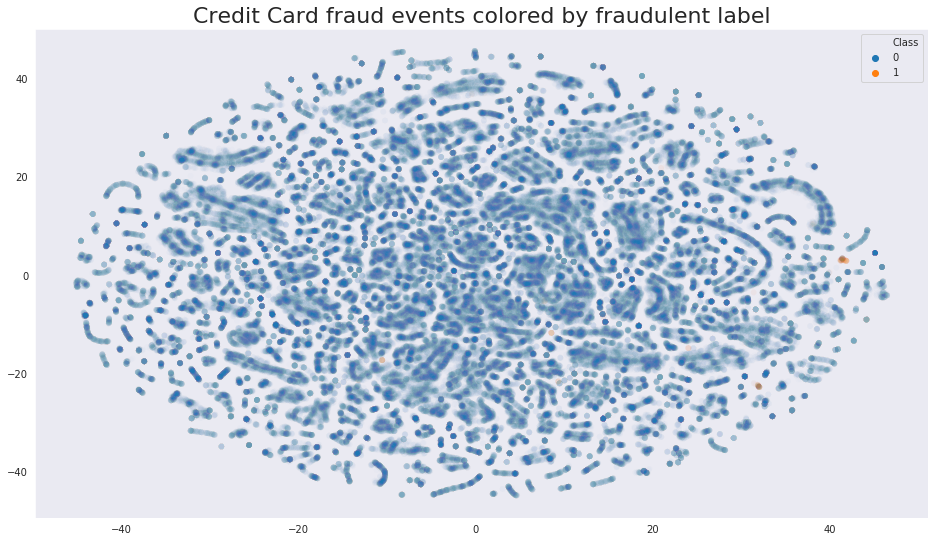

In [8]:
sns.set_style('dark')
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title('Credit Card fraud events colored by fraudulent label', size=22)
sns.scatterplot(x=tsne_red_X[:,0], y=tsne_red_X[:,1], hue=y, alpha=0.01)
plt.show()

### Reduced-dimension visualization observations
##### In fewer dimensions, we can still see some strong trends.
There are a few locations where the fraudulent transactions lie (pictured in orange). Because of the transparency of the icons, we can see a strong presence of fraud stacked up on the east side of the visualization.
### Classification models and prediction probabilities
Below we build models and compute the probabilities of the classes in which they belong. With these figures, we run the values through a precision-recall curve because of the strong imbalance and nature of fraud detection - *positive detection is more important than overall correct labeling.*

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf_log = LogisticRegression(solver='liblinear')
bag_log = BaggingClassifier(base_estimator=clf_log)
bag_log.fit(X_train, y_train)
log_pred = bag_log.predict_proba(X_test)

In [10]:
y_train.value_counts()[1] / len(y_train)

0.0016602796894123312

In [11]:
y_test.value_counts()[1] / len(y_test)

0.001884297133761689

In [12]:
# Very slow, wouldn't recommend
clf_knn = KNeighborsClassifier(n_neighbors=3)
bag_knn = BaggingClassifier(base_estimator=clf_knn, n_estimators=3)
bag_knn.fit(X_train, y_train)
knn_pred = bag_knn.predict_proba(X_test)

In [13]:
# The packaged ensemble, random forests
clf_RF = RandomForestClassifier()
clf_RF.fit(X_train, y_train)
RF_pred = clf_RF.predict_proba(X_test)

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [14]:
# Another ensemble with strong performance
clf_GB = GradientBoostingClassifier()
clf_GB.fit(X_train, y_train)
GB_pred = clf_GB.predict_proba(X_test)

In [15]:
# Measure scores with precision_recall_curve
log_prec, log_rec, log_thresh = precision_recall_curve(y_test, log_pred[:,1], pos_label=1)
knn_prec, knn_rec, knn_thresh = precision_recall_curve(y_test, knn_pred[:,1], pos_label=1)
RF_prec, RF_rec, RF_thresh = precision_recall_curve(y_test, RF_pred[:,1], pos_label=1)
GB_prec, GB_rec, GB_thresh = precision_recall_curve(y_test, GB_pred[:,1], pos_label=1)

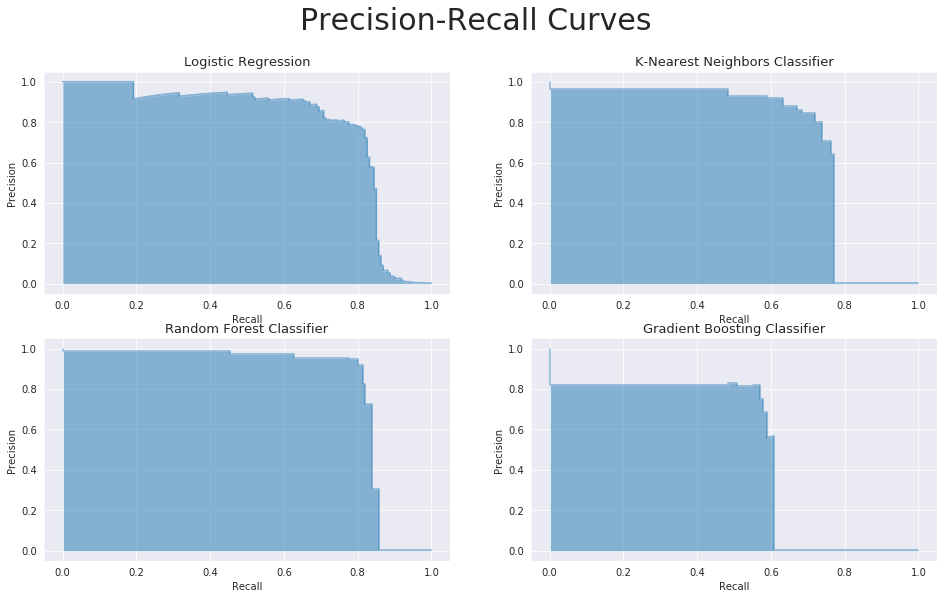

In [16]:
sns.set_style('darkgrid')
step_kwargs = ({'step': 'post'}
              if 'step' in signature(plt.fill_between).parameters
               else {})

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,9), sharex='col', sharey='row')
fig.suptitle('Precision-Recall Curves', size=30)
plt.subplot(2,2,1)
plt.title('Logistic Regression', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(log_rec, log_prec, where='post', alpha=0.5)
plt.fill_between(log_rec, log_prec, alpha=0.5, **step_kwargs)
plt.subplot(2,2,2)
plt.title('K-Nearest Neighbors Classifier', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(knn_rec, knn_prec, where='post', alpha=0.5)
plt.fill_between(knn_rec, knn_prec, alpha=0.5, **step_kwargs)
plt.subplot(2,2,3)
plt.title('Random Forest Classifier', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(RF_rec, RF_prec, where='post', alpha=0.5)
plt.fill_between(RF_rec, RF_prec, alpha=0.5, **step_kwargs)
plt.subplot(2,2,4)
plt.title('Gradient Boosting Classifier', size=13)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(GB_rec, GB_prec, where='post', alpha=0.5)
plt.fill_between(GB_rec, GB_prec, alpha=0.5, **step_kwargs)
plt.show()

## Varying performances
#### Ensembles seem to be good for this problem
The results are not bad in some instances, such as the stock random forest. Others, however, did not fare so well. It is possible that some hyper parameter tuning can help. Below we are going to run a grid search across two classifiers and determine if better results can be obtained. The process is slow - as in several hours, so try at your own peril!

In [18]:
params = {'n_estimators':[10, 100], 'min_samples_split':[2, 4]}
grid = GridSearchCV(clf_RF, param_grid=params, scoring='f1', cv=10)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 100], 'min_samples_split': [2, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [20]:
# Original hyper parameters took more than 8 hours
clf_ada = AdaBoostClassifier()
params2 = {'learning_rate':[1, 1e1, 1e2]}
grid2 = GridSearchCV(clf_ada, param_grid=params2, scoring='f1', cv=10)
grid2.fit(X_train, y_train)

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:164: RuntimeWarning: invalid value encountered in true_divide
  sample_weight /= sample_weight_sum
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-package

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimator_weight < 0)))
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:531: RuntimeWarning: invalid value encountered in greater
  ((sample_weight > 0) |
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:532: RuntimeWarning: invalid value encountered in less
  (estimat

/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:604: RuntimeWarning: invalid value encountered in greater
  return self.classes_.take(pred > 0, axis=0)
/home/seapea/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [1, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

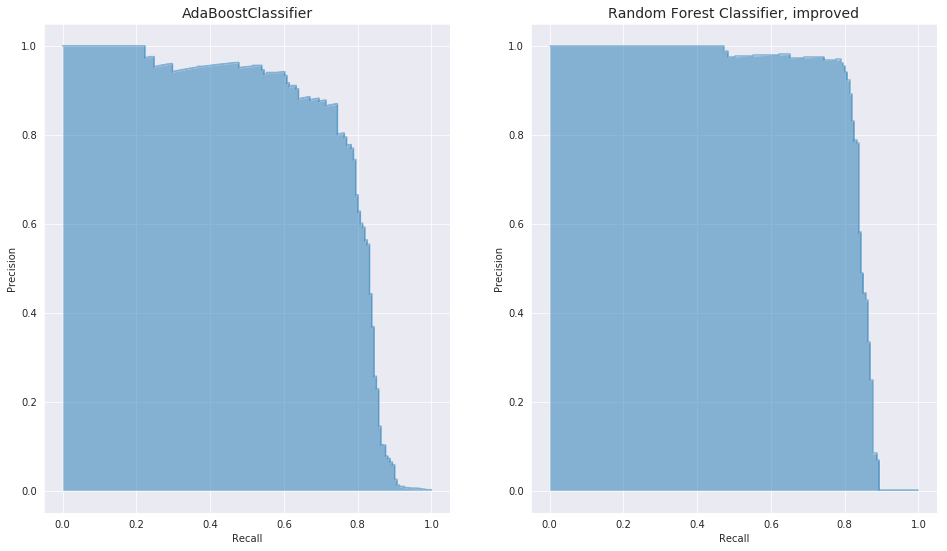

In [25]:
clf_ada = AdaBoostClassifier(**grid2.best_params_)
clf_ada.fit(X_train, y_train)
ada_pred = clf_ada.predict_proba(X_test)
clf_RF2 = RandomForestClassifier(**grid.best_params_)
clf_RF2.fit(X_train, y_train)
RF2_pred = clf_RF2.predict_proba(X_test)

ada_prec, ada_rec, ada_thresh = precision_recall_curve(y_test, ada_pred[:,1], pos_label=1)
RF2_prec, RF2_rec, RF2_thresh = precision_recall_curve(y_test, RF2_pred[:,1], pos_label=1)
plt.subplots(figsize=(16,9))
plt.subplot(1,2,1)
plt.title('AdaBoostClassifier', size=14)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(ada_rec, ada_prec, where='post', alpha=0.5)
plt.fill_between(x=ada_rec, y1=ada_prec, alpha=0.5, **step_kwargs)
plt.subplot(1,2,2)
plt.title('Random Forest Classifier, improved', size=14)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.step(RF2_rec, RF2_prec, where='post', alpha=0.5)
plt.fill_between(x=RF2_rec, y1=RF2_prec, alpha=0.5, **step_kwargs)
plt.show()